<a href="https://colab.research.google.com/github/roxpel/finpay/blob/main/finpay_subscription_propensity_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executive Summary

This case study explores how a B2B SaaS payments platform can increase adoption of its Subscription product.  
Using synthetic merchant and transaction data, I developed a **classification model (propensity model)** to predict which merchants are most likely to adopt Subscriptions.  
This enables better targeting for sales and marketing teams.  
**Final model: XGBoost - ROC AUC: 0.77 · Recall: 0.83 · Precision: 0.30**

---

# Introduction

*   **Problem**: FinPay aims to increase the adoption of its Subscription product among existing merchants.
*   **Objective**: This analysis explores payments and merchants data to identify key characteristics of those likely to adopt Subscriptions and builds a predictive model to inform and optimize subscription adoption campaigns.
*   **Approach**: Data loading and cleaning, data wrangling, EDA, feature engineering, and classification modeling (Logistic Regression, XGBoost).

---

# 1. Data Loading & Initial Validation

## 1.1 Loading Raw Datasets

In [5]:
# Import libraries
from google.colab import drive
import os, textwrap
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

from xgboost import XGBClassifier
from scipy.stats import randint, uniform


# Ensure drive is mounted
try:
    drive.mount('/content/drive')
    print('Google Drive mounted successfully')
except Exception as e:
    print(f'Error mounting Google Drive: {e}')

DATA_DIR = Path('/content/drive/MyDrive/FinPay-Project')

# Ensure files are there
print('\nFiles Colab can see:\n',
      textwrap.indent('\n'.join(os.listdir(DATA_DIR)), ' '))

# Loading the raw data
payments = pd.read_csv(DATA_DIR / 'dstakehome_payments.csv',
                         dtype={'merchant': str},
                         parse_dates=['date'])

merchants = pd.read_csv(DATA_DIR / 'dstakehome_merchants.csv',
                        dtype={'merchant': str},
                        parse_dates=['first_charge_date'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully

Files Colab can see:
  dstakehome_payments.csv
 dstakehome_merchants.csv
 dstakehome_merchants.xlsx
 dstakehome_payments.gsheet
 Data-descriptions.csv
 Data-descriptions.xlsx
 FinPay-DS-Project.ipynb


In [6]:
# Check payments data
payments.head()

,date,merchant,subscription_volume,checkout_volume,payment_link_volume,total_volume
0,2041-05-01 00:00:00+00:00,5d03e714,0,0,0,425340
1,2041-05-01 00:00:00+00:00,da22f154,0,0,0,17326
2,2041-05-01 00:00:00+00:00,687eebc8,79400,0,0,79400
3,2041-05-01 00:00:00+00:00,de478470,268400,0,0,268400
4,2041-05-01 00:00:00+00:00,1e719b8a,0,19895,0,19895


In [7]:
# Check payments summary statistics
payments.describe()

,subscription_volume,checkout_volume,payment_link_volume,total_volume
count,1.577887e+06,1.577887e+06,1.577887e+06,1.577887e+06
mean,3.924766e+04,1.101376e+04,1.843901e+03,3.582914e+05
std,7.253647e+05,1.608574e+05,3.717659e+04,6.488684e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+03
50%,0.000000e+00,0.000000e+00,0.000000e+00,1.987200e+04
75%,0.000000e+00,0.000000e+00,0.000000e+00,7.230000e+04
max,1.083879e+08,3.425907e+07,1.182900e+07,2.243810e+09


In [8]:
# Check merchants data
merchants.head()

,merchant,industry,first_charge_date,country,business_size
0,5d03e714,Education,2032-02-13 00:00:00+00:00,US,medium
1,da22f154,Others,2031-10-16 00:00:00+00:00,US,small
2,687eebc8,Software,2032-07-23 00:00:00+00:00,US,small
3,de478470,Software,2033-03-15 00:00:00+00:00,US,small
4,1e719b8a,Business services,2035-02-12 00:00:00+00:00,IT,small


In [9]:
# Check merchants summary statistics
merchants.describe()

,merchant,industry,first_charge_date,country,business_size
count,23627,23627,23627,23627,23627
unique,23619,30,2872,44,3
top,0.00E+0,Business services,2041-10-27 00:00:00+00:00,US,small
freq,8,3144,43,8595,22853


In [10]:
# Check unique values in merchants, for industry, country, and business size
print('Industries:\n', merchants['industry'].unique())
print('\nCountries:\n', merchants['country'].unique())
print('\nBusiness sizes:\n', merchants['business_size'].unique())

Industries:
 ['Education' 'Others' 'Software' 'Business services' 'Electronics'
 'Personal services' 'Digital goods'
 'Religion, politics & other memberships' 'Merchandise'
 'Grocery & food stores' 'Clothing & accessory' 'Leisure' 'Food & drink'
 'Charity' 'Automotive parts and repair/service shops' 'Construction'
 'Art & photography' 'Travel & lodging' 'Specialty retail'
 'Ticketing & events'
 'Medical services, drugs, testing labs & equipment medium' 'Healthcare'
 'Cosmetics' 'Furnishing' 'Rentals' 'Consulting services'
 'Transportation & car rental' 'Insurance' 'Money transmitters' '0']

Countries:
 ['US' 'IT' 'CA' 'GB' 'NL' 'DE' 'IE' 'AU' 'CY' 'BE' 'ES' 'FR' 'SE' 'CH'
 'DK' 'NO' 'AT' 'NZ' 'LU' 'JP' 'CZ' 'MX' 'BR' 'HK' 'SG' 'LT' 'LV' 'PT'
 'FI' 'SK' 'EE' 'SI' 'MY' 'IN' 'PL' 'MT' 'RO' 'HU' 'GR' 'BG' 'AE' 'TH'
 'HR' 'GI']

Business sizes:
 ['medium' 'small' 'large']


In [11]:
# Check unique values for categorical columns industry, business size, and country, and their distribution

for col in ['industry', 'business_size', 'country']:
    print(f'{col} distribution:\n',
          merchants[col].value_counts(dropna=False),
          '\n', sep='')

industry distribution:
industry
Business services                                           3144
Software                                                    2167
Merchandise                                                 1988
Personal services                                           1922
Others                                                      1732
Digital goods                                               1379
Education                                                   1332
Clothing & accessory                                        1303
Food & drink                                                1275
Grocery & food stores                                        780
Religion, politics & other memberships                       762
Travel & lodging                                             727
Leisure                                                      554
Art & photography                                            508
Charity                                                   

All categorical fields appear clean except for a placeholder value `'0'` in the `industry` column, which will be addressed in the cleaning step.


## 1.2 Quick Sanity Checks (shape, dtypes, uniques)


In [12]:
# Confirming column dtypes of payments data

print('Payments - shape / dtypes')
payments.shape
payments.dtypes

Payments - shape / dtypes


,0
date,"datetime64[ns, UTC]"
merchant,object
subscription_volume,int64
checkout_volume,int64
payment_link_volume,int64
total_volume,int64


In [13]:
# Confirming column dtypes of merchants data

print('Merchants - shape / dtypes')
merchants.shape
merchants.dtypes

Merchants - shape / dtypes


,0
merchant,object
industry,object
first_charge_date,object
country,object
business_size,object


---

# 2. Data Cleaning & Prep

## 2.1 Dealing with Duplicate Merchant IDs

In [14]:
# Check for duplicate rows
print('Duplicate rows in payments:', payments.duplicated().sum())
print('Duplicate rows in merchants:', merchants.duplicated().sum())

# Check for duplicated merchant ID count (should be unique)
print('Duplicate merchant IDs in merchants:', merchants['merchant'].duplicated().sum())

# Check for unique duplicated merchant ID count
print('Unique duplicated merchant IDs in merchants:', merchants[merchants['merchant'].duplicated(keep=False)]['merchant'].nunique())

Duplicate rows in payments: 0
Duplicate rows in merchants: 0
Duplicate merchant IDs in merchants: 8
Unique duplicated merchant IDs in merchants: 2


> 8 duplicate rows (10 records total) belong to only 2 merchant IDs and contain conflicting metadata. Because they represent <0.05 % of the dataset and could introduce ambiguity, all 10 records will be removed in Section 2. This guarantees that every merchant ID is uniquely and consistently defined for downstream analysis.

In [15]:
# Rows that must be dropped
duplicates = merchants[merchants['merchant'].duplicated(keep=False)]['merchant'].unique()

# Drop all rows where the merchant ID is in the duplicates list
merchants_clean = merchants[~merchants['merchant'].isin(duplicates)].copy()

In [16]:
# Check shape before and after removing duplicates
print('Original merchants dataset shape:', merchants.shape)
print('Cleaned merchants dataset shape:', merchants_clean.shape)

# Check for remaining duplicate merchant IDs (should be 0)
print('Remaining duplicate merchant IDs:', merchants_clean['merchant'].duplicated().sum())

if merchants_clean['merchant'].duplicated().sum() == 0:
    print('\n✅ All duplicate merchant IDs are removed (10 rows across 2 merchants) \nThe clean dataset now contains 23,617 unique merchants.')
else:
    print("\n⚠️ Duplicates remain. Let's investigate further.")

Original merchants dataset shape: (23627, 5)
Cleaned merchants dataset shape: (23617, 5)
Remaining duplicate merchant IDs: 0

✅ All duplicate merchant IDs are removed (10 rows across 2 merchants) 
The clean dataset now contains 23,617 unique merchants.


## 2.2 Dealing with Missing Values and Invalid Placeholders

In [17]:
# Check for any missing values in each of the datasets

missing_payments = payments.isnull().sum()
missing_merchants = merchants.isnull().sum()

# Print summary
if missing_payments.sum() == 0 and missing_merchants.sum() == 0:
    print('✅ No missing values detected')
else:
    print('⚠️ Missing values in payments:\n', missing_payments[missing_payments > 0])
    print('⚠️ Missing values in merchants:\n', missing_merchants[missing_merchants > 0])

✅ No missing values detected


In [18]:
# Check for invalid values in the payments dataset

# Define known placeholders
placeholders = ['n/a', 'N/A', 'unknown', '-', '', '0']

# Flag any invalid merchant IDs (choosing a len<3 as a threshold)
invalid_merchants = payments[
    payments['merchant'].str.lower().isin(placeholders)
    | payments['merchant'].str.len().lt(3)
]
# Print summary
if invalid_merchants.empty:
    print('✅ No invalid merchant IDs detected in the payments dataset. Data is consistent and ready for analysis.')
else:
    print(f'⚠️ Found {len(invalid_merchants)} suspicious merchant IDs:')
    display(invalid_merchants['merchant'].value_counts())

✅ No invalid merchant IDs detected in the payments dataset. Data is consistent and ready for analysis.


In [19]:
# Replace placeholder strings with proper NaN

meta_cols = ['industry', 'business_size', 'country', 'first_charge_date']
merchants_clean[meta_cols] = merchants_clean[meta_cols].replace(placeholders, np.nan)

# special case clean-up: some rows have literal '0' in industry
merchants_clean.loc[
    merchants_clean['industry'] == '0', 'industry'
] = np.nan

# Check for missing values (NaN)
merchants_clean.isna().sum()

,0
merchant,0
industry,7
first_charge_date,26
country,0
business_size,0


In [20]:
# Quick post-clean sanity: show distribution of categorical columns

for col in ['industry', 'business_size', 'country']:
    print(f'{col} distribution:\n',
          merchants_clean[col].value_counts(dropna=False),
          '\n', sep='')

industry distribution:
industry
Business services                                           3143
Software                                                    2167
Merchandise                                                 1987
Personal services                                           1922
Others                                                      1729
Digital goods                                               1379
Education                                                   1330
Clothing & accessory                                        1302
Food & drink                                                1275
Grocery & food stores                                        780
Religion, politics & other memberships                       762
Travel & lodging                                             727
Leisure                                                      553
Art & photography                                            508
Charity                                                   

## 2.3 Date Type Conversion

In [21]:
# Convert first_charge_date from object to datetime
merchants_clean['first_charge_date'] = pd.to_datetime(merchants['first_charge_date'], errors='coerce')

# Sanity check: confirm datetime type conversion
merchants_clean.dtypes

,0
merchant,object
industry,object
first_charge_date,"datetime64[ns, UTC]"
country,object
business_size,object


## 2.4 Standardizing Volume Fields (cents to dollars)

In [22]:
# Convert volumes to floats and scale from cents to dollars
volume_cols = ['subscription_volume', 'checkout_volume', 'payment_link_volume', 'total_volume']

for col in volume_cols:
    payments[col] = pd.to_numeric(payments[col], errors='coerce').fillna(0) / 100.0

In [23]:
# Confirming volume fields are now in dollars and in the right dtype
payments[volume_cols].describe()

,subscription_volume,checkout_volume,payment_link_volume,total_volume
count,1.577887e+06,1.577887e+06,1.577887e+06,1.577887e+06
mean,3.924766e+02,1.101376e+02,1.843901e+01,3.582914e+03
std,7.253647e+03,1.608574e+03,3.717659e+02,6.488684e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02
25%,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+01
50%,0.000000e+00,0.000000e+00,0.000000e+00,1.987200e+02
75%,0.000000e+00,0.000000e+00,0.000000e+00,7.230000e+02
max,1.083879e+06,3.425907e+05,1.182900e+05,2.243810e+07


✅ All transaction volume fields have been converted from cents to dollars. This check confirms that the converted values fall within a reasonable and expected range.

---

# 3. Data Wrangling

## 3.1 Product Usage Per Merchant

In [24]:
# In payments dataset, group volume by merchant for each product and total
merchant_product_usage = payments.groupby('merchant')[['subscription_volume','checkout_volume','payment_link_volume','total_volume']].sum()

# Create booleans for product usage per merchant, across each of the product categories
merchant_product_usage['uses_subscription'] = merchant_product_usage['subscription_volume'] > 0
merchant_product_usage['uses_checkout'] = merchant_product_usage['checkout_volume'] > 0
merchant_product_usage['uses_payment_link'] = merchant_product_usage['payment_link_volume'] > 0

# Check merchant product usage shape and data
print("\nMerchant product usage shape:")
print(merchant_product_usage.shape)


Merchant product usage shape:
(23619, 7)


## 3.2 Merchants by Product Usage Cohort

This logic assigns each merchant to a usage cohort based on their combination of product usage across Subscriptions, Checkout, and Payment Links.

In [25]:
# Refined cohort logic

def classify_usage(row):
    s = row['uses_subscription']
    c = row['uses_checkout']
    p = row['uses_payment_link']

    if s:
        if c and p:
            return "Subs + Checkout + Payment Link"
        elif c:
            return "Subs + Checkout"
        elif p:
            return "Subs + Payment Link"
        else:
            return "Subs + Custom UI"
    elif c and p:
        return "Checkout + Payment Link"
    elif c:
        return "Checkout only"
    elif p:
        return "Payment Link only"
    elif row['total_volume'] > 0:
        return "Custom API / Terminal"
    else:
        return "No activity"

# Create new column called usage cohort with the cohort assignment for each merchant
merchant_product_usage['usage_cohort'] = merchant_product_usage.apply(classify_usage, axis=1)

## 3.3 Merchants by Subscription Adoption Status



In [26]:
merchant_product_usage['subscription_status'] = merchant_product_usage['uses_subscription'].map({True: 'Subscribed', False: 'Not Subscribed'})

✅ The table now contains transaction volumes, product usage flags, and a cohort label - ready for merge and modelling.

## 3.4 Merging Usage with Merchant Metadata

In [27]:
# Columns from the merchants table that will be merged (metadata) with clean merchant-level usage data
merged_cols = ["industry", "business_size", "country", "first_charge_date"]

# Merge (clean) merchant-level usage data with merchant metadata
merchant_full = merchant_product_usage.merge(merchants_clean, on='merchant', how='left')

# Check shape of merged dataset
print("Merged shape:", merchant_full.shape)

# post-merge null check on metadata
missing_after_merge = merchant_full[merged_cols].isnull().sum()
if missing_after_merge.sum() == 0:
    print("✅ No missing metadata after merge.")
else:
    print("⚠️ Missing values detected after merge:\n")
    print(missing_after_merge[missing_after_merge > 0])

Merged shape: (23619, 14)
⚠️ Missing values detected after merge:

industry             36
business_size        29
country              29
first_charge_date    55
dtype: int64


### Note on Missing Values Post-Merge

The previous cell's output indicates some missing values (NaNs) in `industry`, `business_size`, `country`, and `first_charge_date` after the merge. This occurs because:

1.  **Unmatched Merchants:** Some merchants in the `payments` data (used to create `merchant_product_usage`) may not have corresponding records in the `merchants_clean` metadata file.
2.  **Pre-existing NaNs:** Certain metadata fields in `merchants_clean` might have been set to NaN during prior cleaning steps (e.g., placeholder replacement or `first_charge_date` coercion to NaT).

For merchants affected, we lack complete demographic or tenure information. These NaNs will be addressed during preprocessing for the modeling phase (e.g., via imputation or by treating them as a distinct 'Unknown' category).

## 3.5 Preview: Final Engineered Dataset for EDA

In [28]:
# Check full cleaned and engineered dataset
merchant_full.head()

# Sanity check: dtypes
merchant_full.dtypes

,0
merchant,object
subscription_volume,float64
checkout_volume,float64
payment_link_volume,float64
total_volume,float64
uses_subscription,bool
uses_checkout,bool
uses_payment_link,bool
usage_cohort,object
subscription_status,object


---

# 4. Exploratory data analysis (EDA)

## 4.1 Merchant-Level Patterns

### 4.1.1 Merchant Total Volume Spread

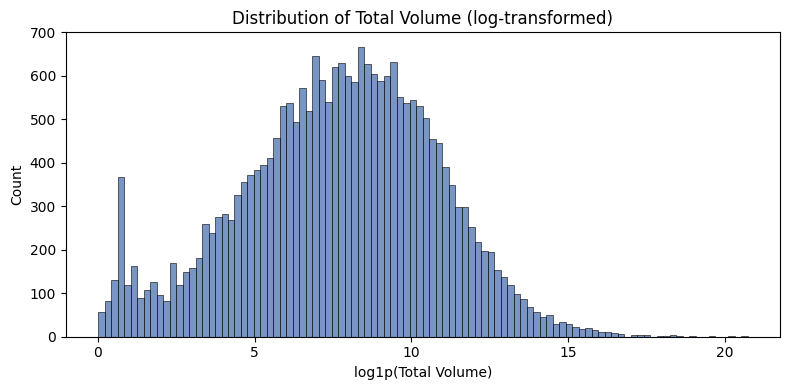

<Figure size 640x480 with 0 Axes>

In [29]:
# Histogram of log1p of total volume distribution
plt.figure(figsize=(8, 4))
sns.histplot((np.log1p(merchant_full['total_volume'])), bins=100, color='#4c72b0')
plt.xlabel("log1p(Total Volume)")
plt.title("Distribution of Total Volume (log-transformed)")
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

> The raw distribution of `total_volume` is heavily right-skewed, driven by a small group of high-volume merchants. Applying a log1p transformation reveals the underlying spread and makes it easier to detect variance across the broader merchant base. This is crucial if `total_volume` is used as a feature later, to avoid extreme values skewing the model.

### 4.1.2 Merchants by Product Usage Cohort

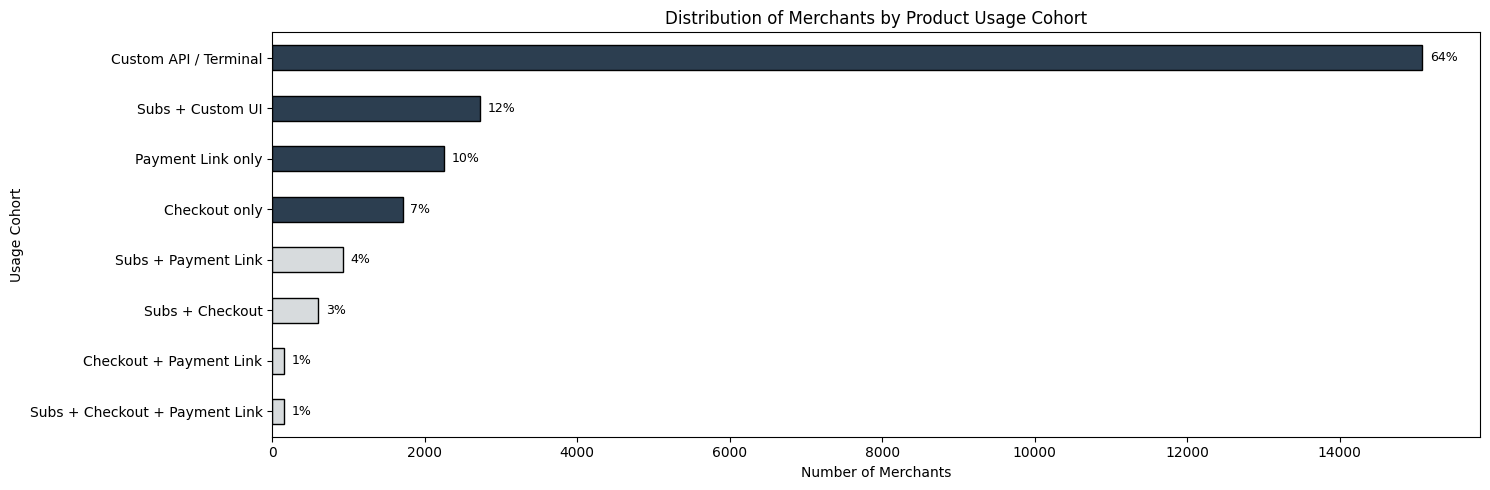

In [30]:
# Get sorted usage cohort counts
cohort_counts = merchant_full['usage_cohort'].value_counts().sort_values()
top_4 = cohort_counts[-4:].index
total_merchants = cohort_counts.sum()

# Set bar colors
highlight_color = '#2C3E50'
neutral_color = '#D7DBDD'
colors = [highlight_color if cohort in top_4 else neutral_color for cohort in cohort_counts.index]

# Plot
plt.figure(figsize=(15, 5))
bars = cohort_counts.plot(kind='barh', color=colors, edgecolor='black')

# Add % labels
for i, (value, name) in enumerate(zip(cohort_counts.values, cohort_counts.index)):
    pct = f"{(value / total_merchants) * 100:.0f}%"
    plt.text(value + 100, i, pct, va='center', fontsize=9)

# Title and labels
plt.title('Distribution of Merchants by Product Usage Cohort')
plt.xlabel('Number of Merchants')
plt.ylabel('Usage Cohort')
plt.tight_layout()
plt.show()

> Over 80% of FinPay merchants fall into 3 core cohorts, none of which use Subscription products.

### 4.1.3 Takeaway
While a small share of merchants drives most volume, the majority operate at modest scales, especially those in **Custom API / Terminal**, **Checkout only**, and **Payment Link only** cohorts. Together, these three **non-subscription segments represent over 80% of the base** but remain largely untapped for Subscriptions.

This imbalance creates a **prime upsell opportunit**y and a significant **class imbalance**, which must be addressed during modeling to avoid bias and ensure high-potential merchants aren’t overlooked.

## 4.2 Industry-Based Patterns

### 4.2.1 Merchants by Industry

In [31]:
# Group by industry and usage cohort, count merchants
industry_summary = merchant_full.groupby(['industry', 'usage_cohort']).size().unstack(fill_value=0)

# Add total merchant count per industry
industry_summary['total_merchants'] = industry_summary.sum(axis=1)

# Count of subscribed merchants per industry (as integer)
sub_counts = merchant_full[merchant_full['subscription_status'] == 'Subscribed'].groupby('industry').size()
industry_summary['subscribed_merchants'] = sub_counts.reindex(industry_summary.index).fillna(0).round().astype(int)

# Add subscription adoption rate
industry_summary['subscription_rate'] = (
    industry_summary['subscribed_merchants'] / industry_summary['total_merchants'] * 100
).round(2)

# Sort by total merchants
industry_summary = industry_summary.sort_values(by='total_merchants', ascending=False)

# Calculate percentage of each industry in the total base
industry_summary['perc_merchants'] = (
    industry_summary['total_merchants'] / industry_summary['total_merchants'].sum() * 100
).round(2)

# Compute cumulative percentage on the sorted order
industry_summary['cum_perc_merchants'] = industry_summary['perc_merchants'].cumsum()

industry_summary.head()

usage_cohort,Checkout + Payment Link,Checkout only,Custom API / Terminal,Payment Link only,Subs + Checkout,Subs + Checkout + Payment Link,Subs + Custom UI,Subs + Payment Link,total_merchants,subscribed_merchants,subscription_rate,perc_merchants,cum_perc_merchants
industry,,,,,,,,,,,,,
Business services,26,167,1679,392,96,32,540,208,3140,876,27.90,13.31,13.31
Software,15,138,901,173,172,36,604,123,2162,935,43.25,9.17,22.48
Merchandise,12,132,1539,144,29,4,99,27,1986,159,8.01,8.42,30.90
Personal services,11,108,1003,252,42,9,312,182,1919,545,28.40,8.14,39.04
Others,13,155,1135,170,53,13,141,47,1727,254,14.71,7.32,46.36


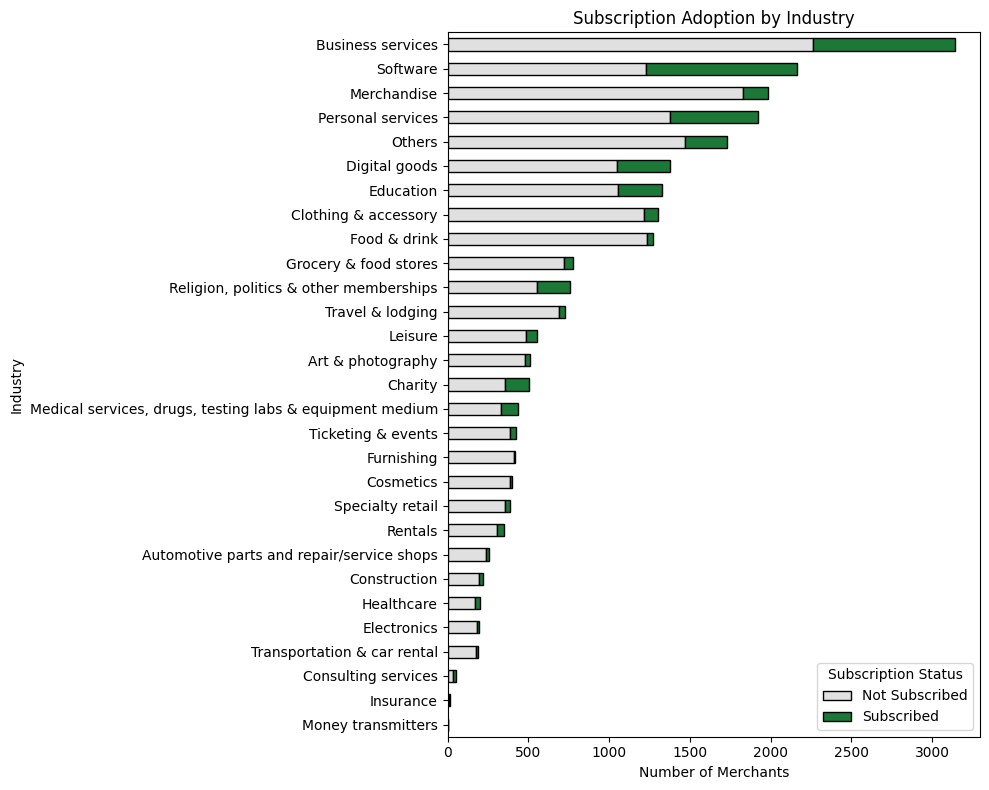

In [32]:
# Extract counts from industry_summary df
sub_status_industry = industry_summary[['total_merchants', 'subscribed_merchants']].copy()

# Rename subscribed_merchants column
sub_status_industry['Subscribed'] = sub_status_industry['subscribed_merchants']

# Calculate 'Not Subscribed'
sub_status_industry['Not Subscribed'] = (
    sub_status_industry['total_merchants'] - sub_status_industry['Subscribed'])

# Sort by Total Merchants for descending order in horizontal plot
sub_status_industry = sub_status_industry.sort_values('total_merchants', ascending=True)

# Plot
colors = ['#e0e0e0', '#1b7837']
ax = sub_status_industry[['Not Subscribed', 'Subscribed']].plot(
    kind='barh',
    stacked=True,
    figsize=(10, 8),
    color=colors,
    edgecolor='black'
)

plt.title('Subscription Adoption by Industry')
plt.xlabel('Number of Merchants')
plt.ylabel('Industry')
plt.legend(title='Subscription Status', loc='lower right')
plt.tight_layout()
plt.show()

> Subscription adoption is highly uneven across industries. Software and Business Services lead, while verticals like Merchandise and Digital Goods underperform.
>
> This validates `industry` as a high-signal feature and suggests latent Subscription potential in adjacent or structurally similar segments.


### 4.2.2 Product Usage Cohorts by Industry

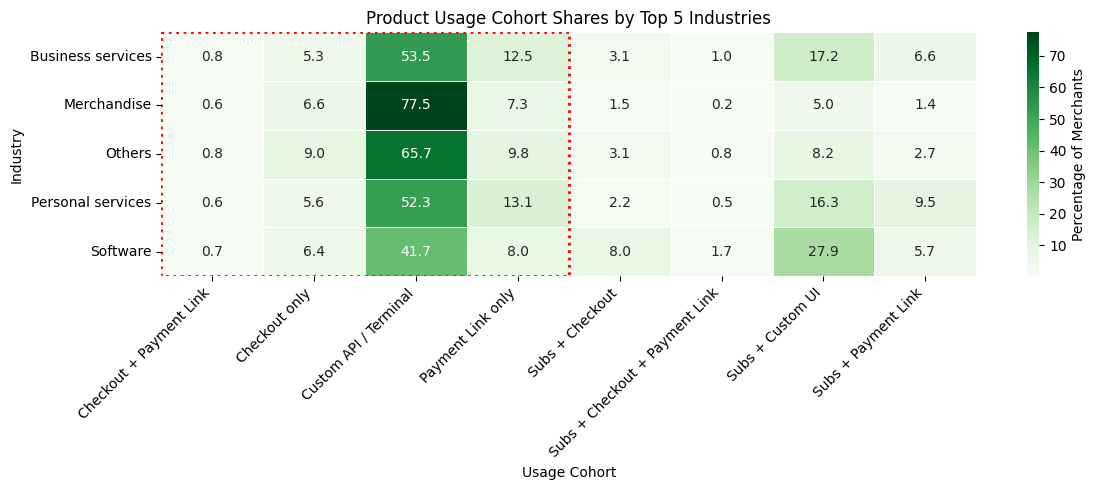

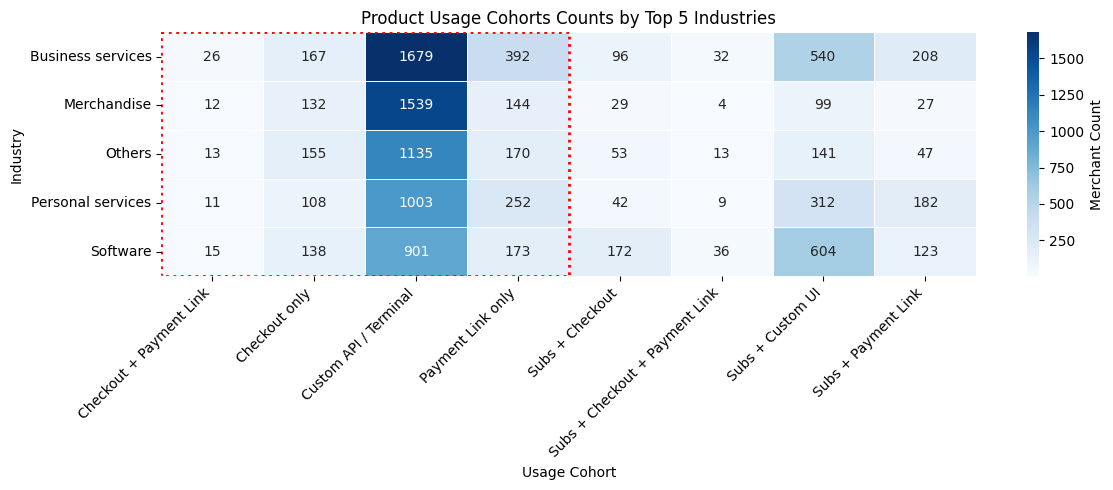

In [33]:
# Get top 5 industries by merchant count
top5_industries = (
    merchant_full['industry']
    .value_counts()
    .head(5)
    .index
)

# Filter to top 5 industries
top5_industries = merchant_full[merchant_full['industry'].isin(top5_industries)]

# Pivot table
heatmap_data = (
    top5_industries.groupby(['industry', 'usage_cohort'])
    .size()
    .unstack(fill_value=0)
)

# Normalize by industry to get percentages
heatmap_pct = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100

# Plot heatmap with red box for percentages
plt.figure(figsize=(12, 5))
ax = sns.heatmap(
    heatmap_pct,
    annot=True,
    fmt=".1f",
    cmap="Greens",
    cbar_kws={'label': 'Percentage of Merchants'},
    linewidths=0.5
)

# Title and labels
plt.title("Product Usage Cohort Shares by Top 5 Industries")
plt.xlabel("Usage Cohort")
plt.ylabel("Industry")
plt.xticks(rotation=45, ha='right')

# Add red dotted box around the first 4 columns (non-subscription cohorts)
start_col = 0
end_col = 4
start_row = 0
end_row = len(heatmap_pct)

# Draw a red dotted rectangle around the first 4 columns
ax.add_patch(plt.Rectangle(
    (start_col, start_row),
    end_col - start_col, end_row,
    fill=False, edgecolor='red', linewidth=2, linestyle='dotted'
))

plt.tight_layout()
plt.show()

# Plot heatmap with red box for absolute numbers
plt.figure(figsize=(12, 5))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar_kws={'label': 'Merchant Count'},
    linewidths=0.5
)

# Title and labels
plt.title("Product Usage Cohorts Counts by Top 5 Industries")
plt.xlabel("Usage Cohort")
plt.ylabel("Industry")
plt.xticks(rotation=45, ha='right')

# Add red dotted box around the first 4 columns (non-subscription cohorts)
start_col = 0
end_col = 4
start_row = 0
end_row = len(heatmap_pct)

# Draw a red dotted rectangle around the first 4 columns
ax.add_patch(plt.Rectangle(
    (start_col, start_row),
    end_col - start_col, end_row,
    fill=False, edgecolor='red', linewidth=2, linestyle='dotted'
))

plt.tight_layout()
plt.show()

> The heatmap confirms that Custom API / Terminal is the dominant entry point across industries (42–78%), offering limited signal for upsell. Meanwhile, Software and Business Services show stronger Subscription cohort penetration, reinforcing their maturity as verticals.
>
> Absolute counts confirm we have enough data for most cohorts, but very rare combinations (e.g. “Subs + Checkout + Payment Link” with less than 1%) should be collapsed to reduce noise and avoid overfitting on sparse classes.



### 4.2.3 Takeaway

1. **Industry Is a Strong Predictor of Subscription Adoption**  
   Adoption skews heavily toward Software and Business Services, while lagging in segments like Merchandise and Digital Goods. This reinforces the value of `industry` as a predictive feature in the model.

2. **Product Usage Patterns Vary Widely by Vertical**  
   Custom API / Terminal is the default usage path across industries, but Subscription mixes, especially “Subs + Custom UI”, are concentrated in Software, Business Services, and Personal Services. These segments indicate higher technical maturity and potential for higher lifetime value (LTV).

3. **Long-Tail Industries Should Be Grouped**  
   To support modeling, long-tail industries will be grouped into broader thematic cohorts (e.g., Retail, Services, Creative) to reduce sparsity, capture generalizable behavior, and surface latent Subscription potential in underpenetrated segments.

4. **Sparse Cohorts Should Be Collapsed for Stability**  
   Rare combinations like “Subs + Checkout + Payment Link” are too infrequent to model separately. These will be consolidated into broader Subscription cohorts (e.g., “Subs + Checkout”) to retain signal without overfitting on noise.

## 4.3 Country-Based Patterns

### 4.3.1 Merchants by Country

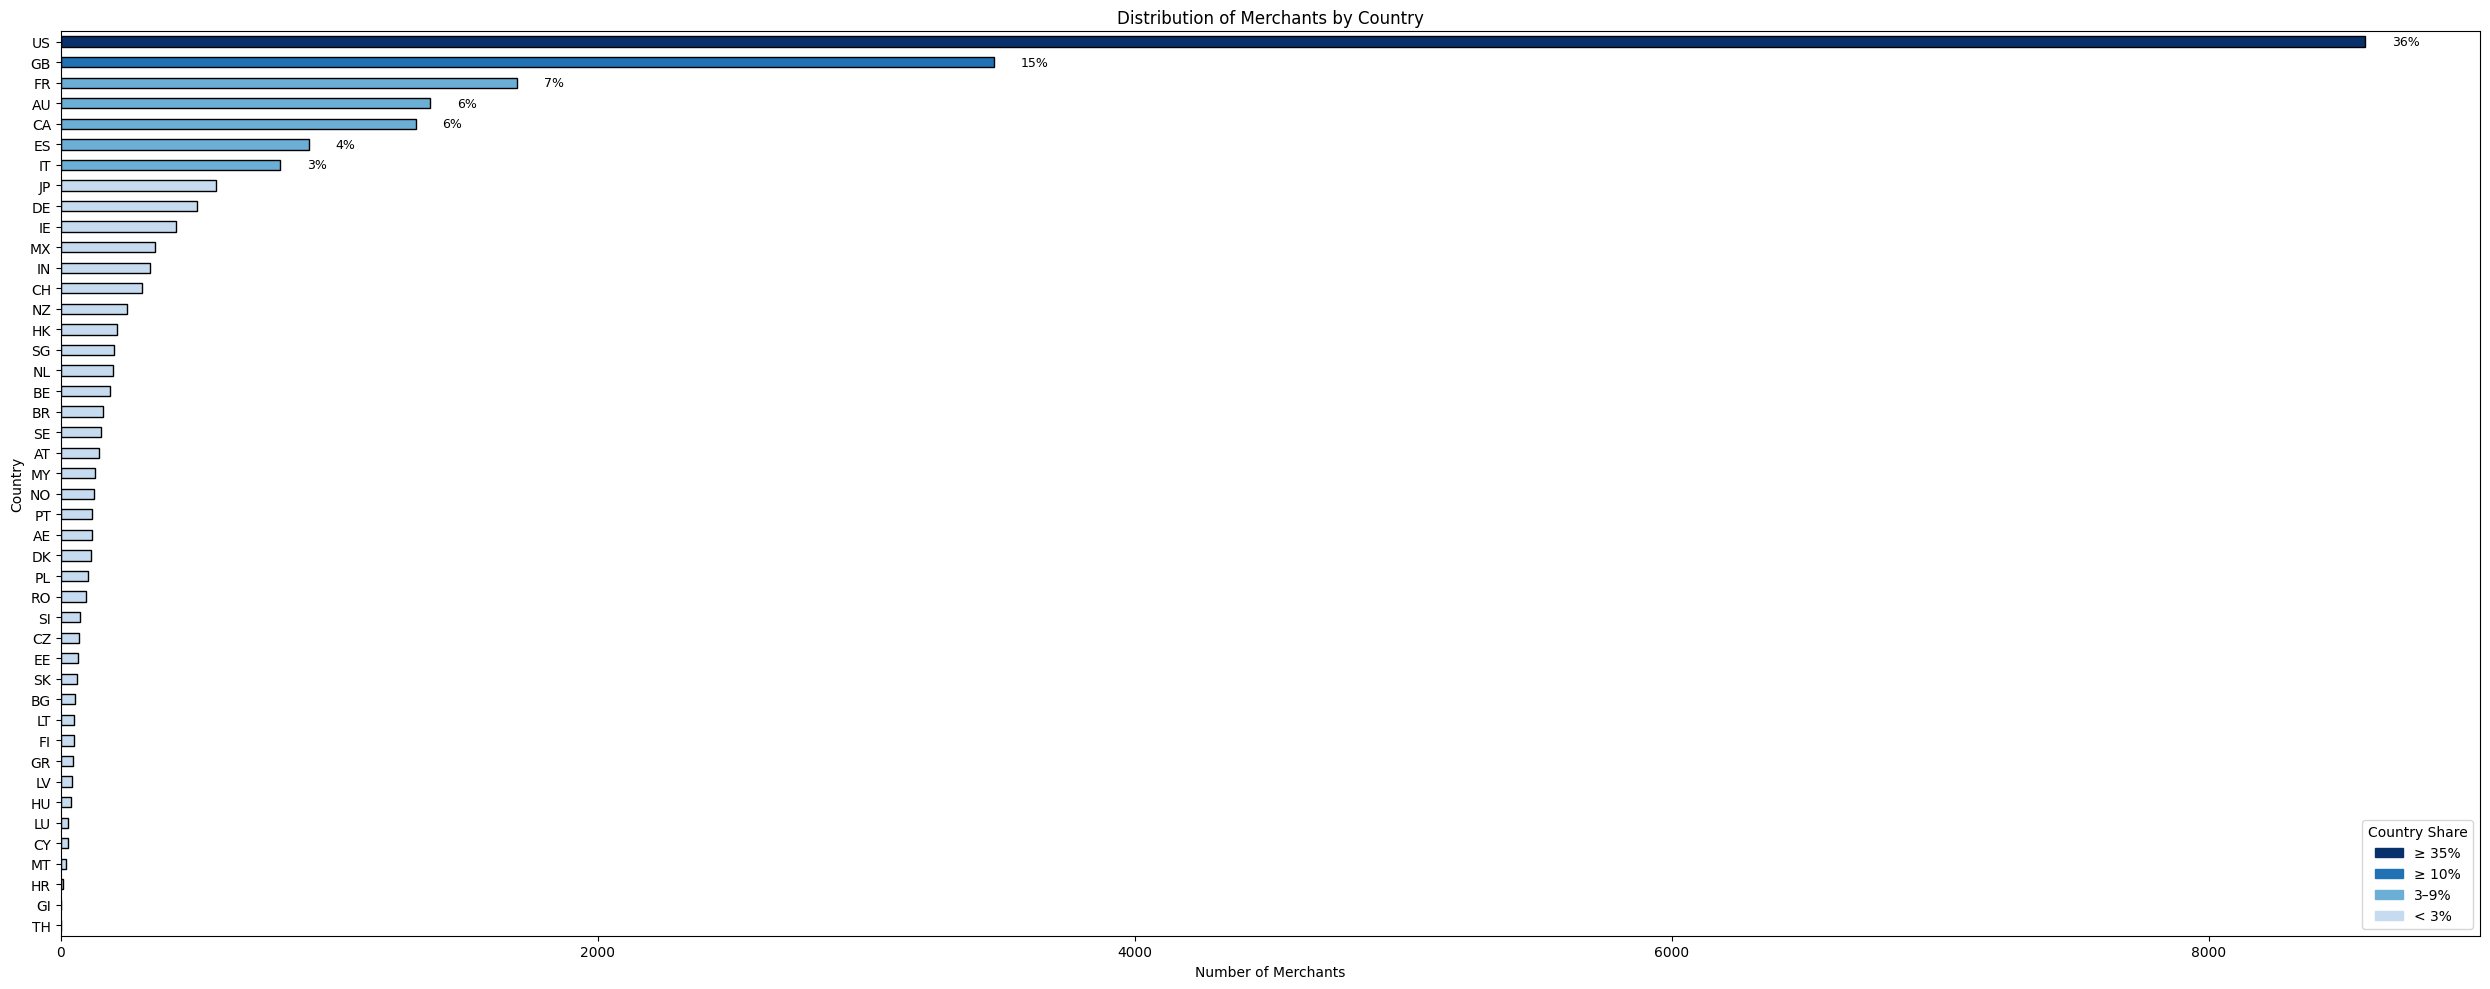

In [34]:
# Get country distribution
country_counts = merchant_full['country'].value_counts().sort_values()
total_merchants = country_counts.sum()

# Assign colors and prepare percentage labels
colors = []
percent_labels = []
for count in country_counts.values:
    pct = (count / total_merchants) * 100
    percent_labels.append(pct)
    if pct >= 35:
        colors.append('#08306B')
    elif pct >= 10:
        colors.append('#2171B5')
    elif pct >= 3:
        colors.append('#6BAED6')
    else:
        colors.append('#C6DBEF')

# Plot
plt.figure(figsize=(25, 10))
country_counts.plot(kind='barh', color=colors, edgecolor='black')

# Add % labels for countries with ≥ 3%
for i, (value, pct) in enumerate(zip(country_counts.values, percent_labels)):
    if pct >= 3:
        plt.text(value + 100, i, f"{pct:.0f}%", va='center', fontsize=9)

# Labels and title
plt.title('Distribution of Merchants by Country')
plt.xlabel('Number of Merchants')
plt.ylabel('Country')
plt.tight_layout()

# Custom legend
legend_patches = [
    mpatches.Patch(color='#08306B', label='≥ 35%'),
    mpatches.Patch(color='#2171B5', label='≥ 10%'),
    mpatches.Patch(color='#6BAED6', label='3–9%'),
    mpatches.Patch(color='#C6DBEF', label='< 3%')
]
plt.legend(handles=legend_patches, title='Country Share', loc='lower right')

plt.show()

> The United States and Great Britain dominate FinPay's merchant base, accounting for over half of total volume - the United States alone representing over 1/3. This geographic concentration justifies treating `country` as a key segmentation variable in both modeling and GTM strategy, especially when prioritizing markets by impact potential.
>
> France, Australia, Canada, Spain, and Italy make up the next tier of contributors. While smaller in absolute terms, they are still significant and may benefit from regional targeting or grouped strategies to optimize Subscription adoption efforts.

### 4.3.2 Subscription Adoption Status by Country

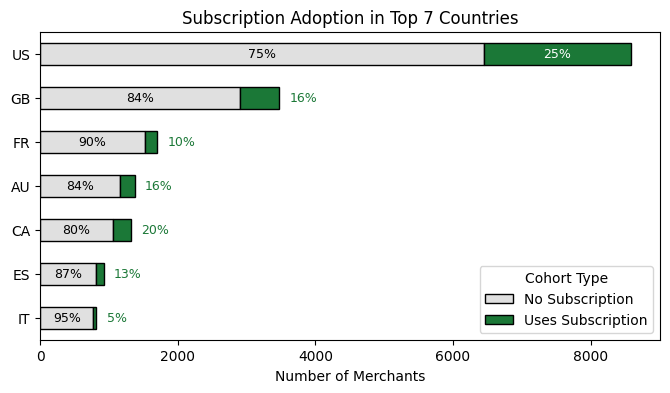

In [35]:
# Get top 7 countries by merchant count
top7_countries = merchant_full['country'].value_counts().nlargest(7).index

# Flag: uses Subscription or Not
top7_countries = merchant_full[merchant_full['country'].isin(top7_countries)]

# Group by country and subscription flag
country_subs = (
    top7_countries.groupby(['country', 'uses_subscription'])
           .size()
           .unstack(fill_value=0)
           .rename(columns={False: 'No Subscription', True: 'Uses Subscription'})
)

# Add and store Total
country_subs = country_subs.loc[(country_subs['No Subscription'] + country_subs['Uses Subscription']).sort_values(ascending=True).index]

# Plot
ax = country_subs.plot(kind='barh',
                       stacked=True,
                       color=['#e0e0e0', '#1b7837'],
                       edgecolor='black',
                       figsize=(8, 4))

# Add % labels on bars
for i, (no_sub, uses_sub) in enumerate(zip(country_subs['No Subscription'], country_subs['Uses Subscription'])):
    total = no_sub + uses_sub
    no_pct = (no_sub / total) * 100
    use_pct = (uses_sub / total) * 100

    # Label for No Subscription
    ax.text(no_sub / 2, i, f'{no_pct:.0f}%', va='center', ha='center', color='black', fontsize=9)

    # Label for Uses Subscription
    if use_pct <= 21:
        ax.text(no_sub + uses_sub + 150, i, f'{use_pct:.0f}%', va='center', ha='left', color='#1b7837', fontsize=9)
    else:
        ax.text(no_sub + uses_sub / 2, i, f'{use_pct:.0f}%', va='center', ha='center', color='white', fontsize=9)

# Labels and title
ax.set_xlabel('Number of Merchants')
ax.set_ylabel('')
ax.set_title('Subscription Adoption in Top 7 Countries')

# Move legend to lower right
ax.legend(title='Cohort Type',
          loc='lower right',
          frameon=True)

plt.show()

> Subscription adoption is highest in the US (25%) and Great Britain (16%), but drops sharply in France, Australia, and Canada, despite sizable merchant bases.
>
> These mid-volume, low-adoption markets present clear whitespace for targeted Subscription growth efforts (e.g., through localized enablement, product education, or bundling campaigns).

### 4.3.3 Product Usage Cohorts by Country

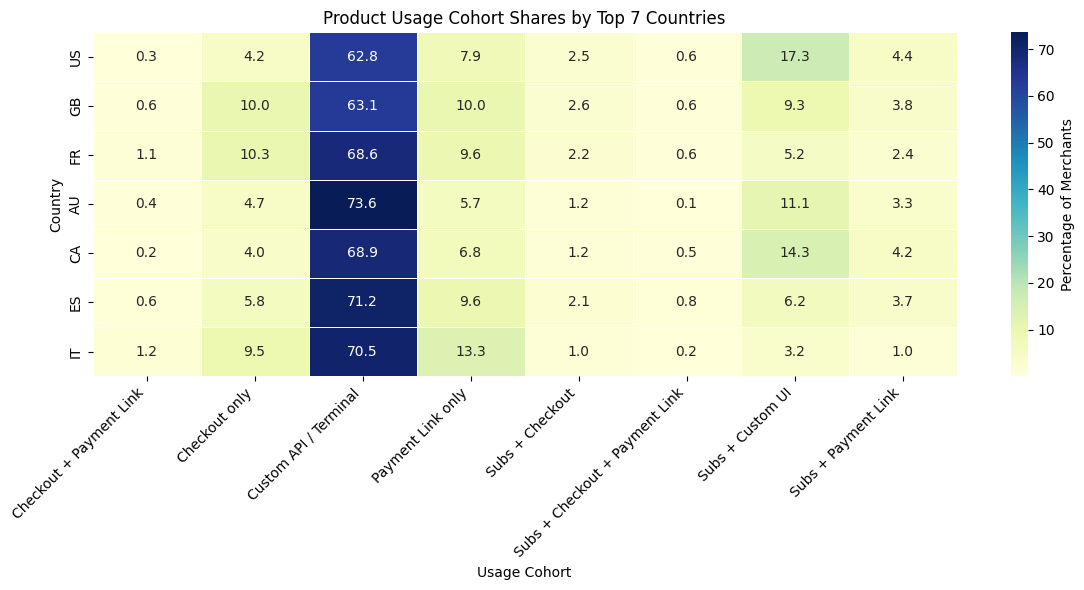

In [36]:
# Get top 7 countries by merchant count
top7_countries = merchant_full['country'].value_counts().nlargest(7).index

# Filter to top 7 countries
top_countries = merchant_full[merchant_full['country'].isin(top7_countries)]

# Create pivot table of raw counts: country × usage cohort
heatmap_data = (
    top_countries.groupby(['country', 'usage_cohort'])
            .size()
            .unstack(fill_value=0)
)

# Normalize row-wise to get % breakdown per country
heatmap_pct = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100

# Sort countries by total merchant volume
sorted_countries = heatmap_data.sum(axis=1).sort_values(ascending=False).index
heatmap_pct_sorted = heatmap_pct.loc[sorted_countries]

# Plot the heatmap (percentages)
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heatmap_pct_sorted,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Percentage of Merchants'}
)

# Format axis labels
plt.title("Product Usage Cohort Shares by Top 7 Countries")
plt.xlabel("Usage Cohort")
plt.ylabel("Country")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This chart confirms earlier trends while adding nuance:  
>
> *   United States and Great Britain over-index on “Subs + Custom UI,” suggesting more technically mature merchant bases
> *   Southern Europe (Spain, Italy) skews heavily toward “Payment Link only,” pointing to a no-code upsell opportunity
>
> These cohort preferences reinforce the importance of regional product usage patterns when building predictive features.


### 4.3.4 Takeaway

1. **Merchant Volume Concentration**  
   The United States and Great Britain account for over half of FinPay's merchant base, with the United States alone over 1/3. This geographic skew highlights the need for country-aware modeling and GTM prioritization.

2. **Subscription Adoption Gaps**  
   While the Unites and Great Britain show strong Subscription uptake, France, Australia, and Canada remain underpenetrated despite meaningful volume, making them ideal targets for expansion.

3. **Cohort Preferences Add Depth**  
   The heatmap confirms and deepens earlier insights:  
   - **United States/Great Britain lead** in mature, high-integration Subscription use (i.e. Custom UI)  
   - **Southern Europe** leans on simpler flows (Payment Link), indicating potential for no-code Subscription onboarding  

This supports the inclusion of `country` and `usage_cohort` as modeling features and highlights where tailored GTM plays can drive impact.


## 4.4 Business Size-Based Patterns

### 4.4.1 Merchants By Business Size

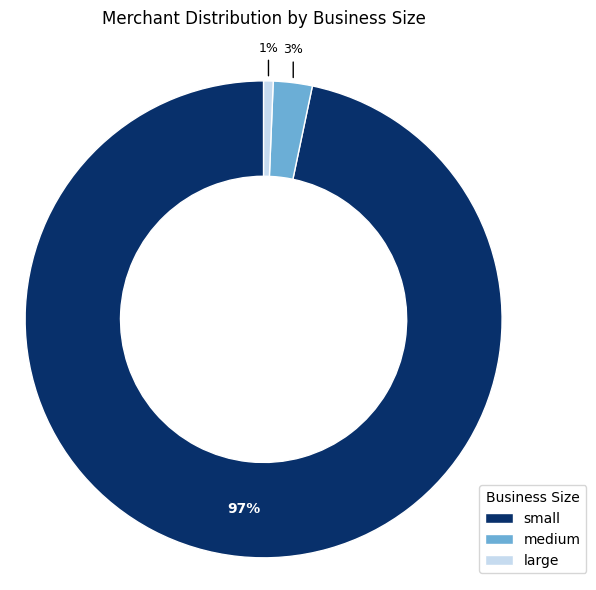

In [37]:
# Business size counts
size_counts = merchant_full['business_size'].value_counts()
labels = size_counts.index
sizes = size_counts.values
colors = ['#08306B', '#6BAED6', '#C6DBEF']

# Plot
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=None,
    colors=colors,
    autopct='%1.0f%%',
    startangle=90,
    pctdistance=0.8,
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)

# Hide all default labels
for text in texts:
    text.set_visible(False)

# Adjust percent labels inside the donut
for i, autotext in enumerate(autotexts):
    if labels[i] == 'small':
        autotext.set_color('white')
        autotext.set_fontsize(10)
        autotext.set_weight('bold')
    else:
        autotext.set_visible(False)  # Hide for medium/large

# Add external callout lines for medium and large
for i, label in enumerate(labels):
    if label != 'small':
        angle = (wedges[i].theta2 + wedges[i].theta1) / 2
        angle_rad = np.deg2rad(angle)

        # Start exactly at edge of the wedge
        x = np.cos(angle_rad) * 1.01
        y = np.sin(angle_rad) * 1.01

        # End point directly above the start
        x_end = x
        y_end = y + 0.1

        # Draw line
        ax.annotate(f"{sizes[i]/sizes.sum():.0%}",
                    xy=(x, y),
                    xytext=(x_end, y_end),
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    arrowprops=dict(arrowstyle='-', color='black', linewidth=1))


# Legend and title
ax.legend(wedges, labels, title='Business Size', loc='lower right', bbox_to_anchor=(1.15,0))
ax.set_title('Merchant Distribution by Business Size', pad=25)
ax.axis('equal')
plt.tight_layout()
plt.show()

> Small businesses account for 97% of FinPay's merchant base, making them the dominant source of Subscription adoption behavior. Medium and large businesses are too rare to drive aggregate patterns despite slightly higher adoption rates.

### 4.4.2 Takeaway

- **Modeling efforts should focus on small businesses**, as they overwhelmingly represent FinPay's merchant base and drive nearly all adoption behavior
- While medium and large businesses may show higher Subscription rates, their low volume means they should not overly influence feature design or evaluation
- GTM strategies should be tailored to the constraints and needs of small merchants, not enterprise flows


## 4.5 Time Based Adoption Patterns

### 4.5.1 Merchants Count Over Time

<ipython-input-38-60b966fa73f8>:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merchant_full['signup_month'] = merchant_full['first_charge_date'].dt.to_period('M')


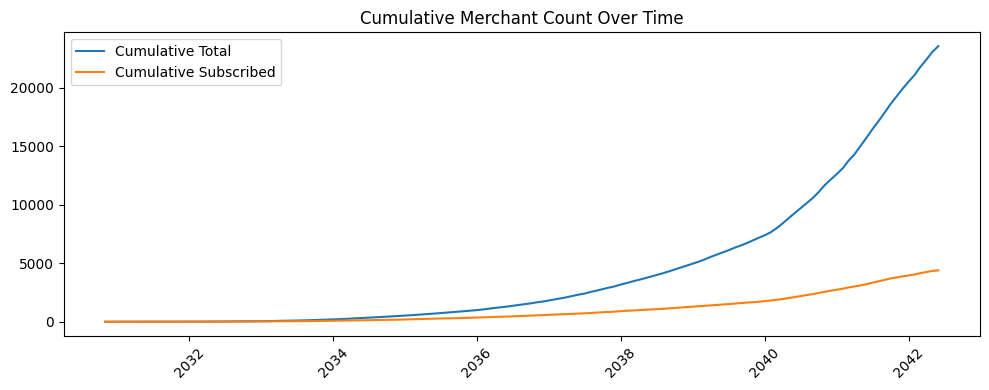

In [38]:
# Use the latest first_charge_date in the dataset as the effective 'today'
analysis_cutoff = merchant_full['first_charge_date'].max().normalize()

# Calculate tenure years with the cutoff
merchant_full['tenure_years'] = (
    (analysis_cutoff - merchant_full['first_charge_date']).dt.days / 365.25
)

# Create monthly signup cohort
merchant_full['signup_month'] = merchant_full['first_charge_date'].dt.to_period('M')

# Aggregate adopters and total merchants per signup cohort
adoption_by_month = (
    merchant_full
      .groupby('signup_month')
      .agg(total_merchants      = ('merchant', 'count'),
           subscribed_merchants = ('uses_subscription', 'sum'))
      .sort_index()
      .reset_index()
)

# Convert signup_month values to datetime for plotting
adoption_by_month['month_dt'] = adoption_by_month['signup_month'].dt.to_timestamp()

# Compute cumulative adoption
adoption_by_month['cumulative_total'] = adoption_by_month['total_merchants'].cumsum()
adoption_by_month['cumulative_subscribed'] = adoption_by_month['subscribed_merchants'].cumsum()
adoption_by_month['cumulative_adoption_rate'] = (
    (adoption_by_month['cumulative_subscribed'] / adoption_by_month['cumulative_total'] * 100).astype(int)
)

# Plot
plt.figure(figsize=(10,4))
plt.plot(adoption_by_month['month_dt'], adoption_by_month['cumulative_total'],
         label='Cumulative Total')
plt.plot(adoption_by_month['month_dt'], adoption_by_month['cumulative_subscribed'],
         label='Cumulative Subscribed')

plt.legend()
plt.xticks(rotation=45)
plt.title('Cumulative Merchant Count Over Time')
plt.tight_layout()
plt.show()

> FinPay's merchant base is growing rapidly, but newer merchants aren’t adopting Subscriptions at the same pace, deepening the adoption gap.

### 4.5.2 Merchants Tenure Distribution

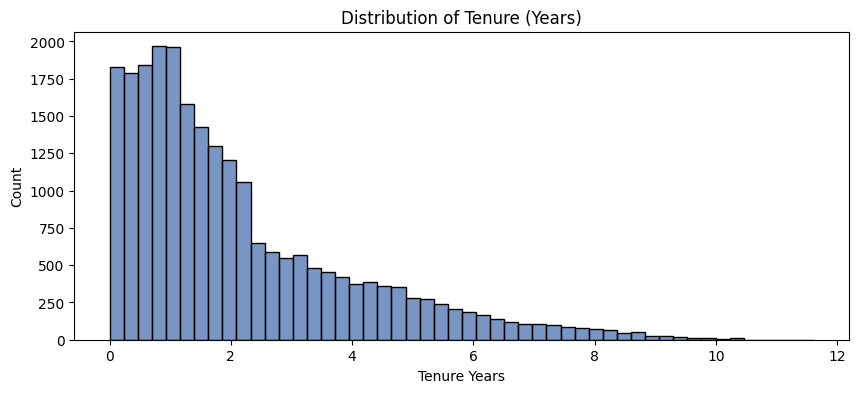

In [39]:
# Histogram of distribution of tenure
plt.figure(figsize=(10, 4))
sns.histplot(merchant_full['tenure_years'].dropna(), bins=50, color="#4c72b0")
plt.title("Distribution of Tenure (Years)")
plt.xlabel("Tenure Years")
plt.ylabel("Count")
plt.show()

> The majority of FinPay merchants are still early in their lifecycle, with tenure heavily concentrated under 2 years. The long right tail confirms a classic growth-stage distribution. This skew highlights the importance of transforming `tenure_years` (e.g. log1p) and suggests that many merchants may not yet have had time to adopt advanced products like Subscriptions.

### 4.5.3 Takeaway
FinPay's merchant base is **expanding rapidly**, but **newer signups are not adopting Subscriptions at the same pace**, widening the **adoption gap** over time. Coupled with a tenure distribution skewed toward recent signups, this points to a clear whitespace: **younger merchants are high-potential candidates** for onboarding, education, or lifecycle nudges.

Going forward, `tenure_years` should be treated as a core predictive feature, and both modeling and GTM strategy should explicitly account for time-to-adopt behavior.

---

# 5. Feature Engineering

In [40]:
# Check dataset prior to starting feature engineering
merchant_full.head()

,merchant,subscription_volume,checkout_volume,payment_link_volume,total_volume,uses_subscription,uses_checkout,uses_payment_link,usage_cohort,subscription_status,industry,first_charge_date,country,business_size,tenure_years,signup_month
0,0.00E+00,118.32,1832.06,2633.4,28108.40,True,True,True,Subs + Checkout + Payment Link,Subscribed,NaN,NaT,NaN,NaN,NaN,NaT
1,00085cb5,0.00,51600.00,0.0,51600.00,False,True,False,Checkout only,Not Subscribed,Software,2041-01-28 00:00:00+00:00,BG,small,1.396304,2041-01
2,000a45ba,925.00,0.00,0.0,1425.00,True,False,False,Subs + Custom UI,Subscribed,Others,2040-06-01 00:00:00+00:00,US,small,2.056126,2040-06
3,000e2c0e,5201.24,0.00,0.0,9870.07,True,False,False,Subs + Custom UI,Subscribed,Education,2039-09-21 00:00:00+00:00,SG,small,2.751540,2039-09
4,001111d7,0.00,0.00,0.0,18659.95,False,False,False,Custom API / Terminal,Not Subscribed,Transportation & car rental,2042-04-24 00:00:00+00:00,SK,small,0.161533,2042-04


## 5.1 Usage Cohorts Consolidation

The `usage_cohort` column captures subscription usage. This is useful for EDA but will introduce data leakage in modeling. To avoid this, I redefined the feature to reflect only non-subscription product usage patterns (e.g., Payment Link only, Checkout only). This preserves relevant behavioral signals while maintaining modeling integrity.

In [41]:
# Redefine usage_grouped to avoid label leakage

def classify_non_sub_usage(row):
    c = row['uses_checkout']
    p = row['uses_payment_link']

    if c and p:
        return "Checkout + Payment Link"
    elif c:
        return "Checkout"
    elif p:
        return "Payment Link"
    elif row['total_volume'] > 0:
        return "Custom API / Terminal"
    else:
        return "No activity"

# Apply the function
merchant_full['usage_grouped'] = merchant_full.apply(classify_non_sub_usage, axis=1)

## 5.2 Industry Buckets

In [42]:
industry_bucket_map = {
    # High-volume stand-alones
    'Business services'                               : 'Business Services',
    'Software'                                        : 'Software / Tech',
    'Merchandise'                                     : 'Retail & Merchandise',
    'Personal services'                               : 'Personal Services',

    # Mid-volume distinct segments
    'Digital goods'                                   : 'Digital Goods',
    'Education'                                       : 'Education & Training',
    'Food & drink'                                    : 'Food & Hospitality',

    # Retail sub-categories  →  roll up
    'Clothing & accessory'                            : 'Retail & Merchandise',
    'Grocery & food stores'                           : 'Retail & Merchandise',
    'Specialty retail'                                : 'Retail & Merchandise',
    'Furnishing'                                      : 'Retail & Merchandise',
    'Cosmetics'                                       : 'Retail & Merchandise',
    'Electronics'                                     : 'Retail & Merchandise',

    # Travel / Leisure cluster
    'Travel & lodging'                                : 'Travel & Leisure',
    'Leisure'                                         : 'Travel & Leisure',
    'Ticketing & events'                              : 'Travel & Leisure',
    'Transportation & car rental'                     : 'Travel & Leisure',

    # Creative / Media / Non-profit
    'Art & photography'                               : 'Creative & Media',
    'Charity'                                         : 'Non-Profit & Membership',
    'Religion, politics & other memberships'          : 'Non-Profit & Membership',

    # Health-related
    'Medical services, drugs, testing labs & equipment medium' : 'Healthcare',
    'Healthcare'                                      : 'Healthcare',

    # Trades / Auto / Construction
    'Automotive parts and repair/service shops'       : 'Auto & Construction',
    'Construction'                                    : 'Auto & Construction',

    # Finance / Insurance
    'Insurance'                                       : 'Finance & Insurance',
    'Money transmitters'                              : 'Finance & Insurance',
}

# Apply with fallback 'Other'
merchant_full['industry_bucket'] = (
    merchant_full['industry'].map(industry_bucket_map).fillna('Other')
)

## 5.3 Country Buckets

In [43]:
# Keep every country at or above the 3 % threshold
THRESHOLD = 0.03

country_share = merchant_full['country'].value_counts(normalize=True)
keep_countries = country_share[country_share >= THRESHOLD].index.tolist()

# Bucket everything else as 'Other'
merchant_full['country_grouped'] = merchant_full['country'].apply(
    lambda c: c if c in keep_countries else 'Other'
)

# Quick sanity-check
print(merchant_full['country_grouped'].value_counts())

country_grouped
US       8580
Other    5428
GB       3474
FR       1698
AU       1376
CA       1321
ES        924
IT        818
Name: count, dtype: int64


## 5.4 Volume & Tenure Transformation

In [44]:
# Log Transform + Winsorization

# Binary target for modeling
merchant_full['subscription_status_bin'] = (
    merchant_full['subscription_status'].eq('Subscribed').astype(int)
)

# Winsorize total_volume at 99th percentile
p99 = merchant_full['total_volume'].quantile(0.99)
merchant_full['total_volume_capped'] = np.minimum(merchant_full['total_volume'], p99)

# Apply log1p transformation to reduce skew
merchant_full['total_volume_log'] = np.log1p(merchant_full['total_volume_capped'])
merchant_full['tenure_years_log'] = np.log1p(merchant_full['tenure_years'])

# Sanity check
merchant_full[['total_volume', 'total_volume_log', 'tenure_years', 'tenure_years_log']].describe()

,total_volume,total_volume_log,tenure_years,tenure_years_log
count,2.361900e+04,23619.000000,23564.000000,23564.000000
mean,2.393595e+05,7.659872,2.127197,0.980315
std,8.219146e+06,3.098932,1.901516,0.554697
min,1.000000e-02,0.009950,0.000000,0.000000
25%,2.893250e+02,5.671001,0.747433,0.558148
50%,2.560110e+03,7.848196,1.541410,0.932719
75%,1.949975e+04,9.878208,2.992471,1.384410
max,9.892636e+08,14.455723,11.622177,2.535455


`log1p` transformation was applied to both `total_volume` and `tenure_years` to reduce right skew and improve numerical stability. Volume was first capped at the 99th percentile to minimize the influence of extreme outliers (i.e., winsorization). This prepares both features for better interpretability and performance in downstream modeling.

In [45]:
# Impute missing tenure values with mean and report how many were filled
# (total_volume_log is already NA-free - the source column had no nulls and was left joined)

n_missing = merchant_full['tenure_years_log'].isna().sum()
merchant_full['tenure_years_log'] = merchant_full['tenure_years_log'].fillna(merchant_full['tenure_years_log'].mean())
print(f"✅ Filled {n_missing} missing values in 'tenure_years_log' with the column mean")

✅ Filled 55 missing values in 'tenure_years_log' with the column mean


---

# 6. Modeling

In [46]:
# Preview model ready df
merchant_full.head()

,merchant,subscription_volume,checkout_volume,payment_link_volume,total_volume,uses_subscription,uses_checkout,uses_payment_link,usage_cohort,subscription_status,...,business_size,tenure_years,signup_month,usage_grouped,industry_bucket,country_grouped,subscription_status_bin,total_volume_capped,total_volume_log,tenure_years_log
0,0.00E+00,118.32,1832.06,2633.4,28108.40,True,True,True,Subs + Checkout + Payment Link,Subscribed,...,NaN,NaN,NaT,Checkout + Payment Link,Other,Other,1,28108.40,10.243859,0.980315
1,00085cb5,0.00,51600.00,0.0,51600.00,False,True,False,Checkout only,Not Subscribed,...,small,1.396304,2041-01,Checkout,Software / Tech,Other,0,51600.00,10.851296,0.873928
2,000a45ba,925.00,0.00,0.0,1425.00,True,False,False,Subs + Custom UI,Subscribed,...,small,2.056126,2040-06,Custom API / Terminal,Other,US,1,1425.00,7.262629,1.117148
3,000e2c0e,5201.24,0.00,0.0,9870.07,True,False,False,Subs + Custom UI,Subscribed,...,small,2.751540,2039-09,Custom API / Terminal,Education & Training,Other,1,9870.07,9.197364,1.322166
4,001111d7,0.00,0.00,0.0,18659.95,False,False,False,Custom API / Terminal,Not Subscribed,...,small,0.161533,2042-04,Custom API / Terminal,Travel & Leisure,Other,0,18659.95,9.834188,0.149741


## 6.1 Feature Selection Rationale

| Feature | Type | Why it matters | Pre-processing notes |
|---------|------|----------------|----------------------|
| **industry_bucket** | Categorical | Subscription adoption skews sharply by vertical (Software & Business Services lead; Merchandise lags) | Group long tail sectors into ±5 buckets (e.g., Retail, Services, Creative); one hot encode |
| **usage_grouped** | Categorical | Product-mix cohorts were the single strongest behavioral predictor of Subscription uptake in EDA | Collapse the ultra-rare “Subs + Checkout + PL” into “Subs + Checkout”; one hot encode the resulting 6 cohorts |
| **country_grouped** | Categorical | Geography matters: US & GB = high-volume / high-adoption; FR / AU / CA = mid-volume / low-adoption | One hot encode 4 groups: United States, Great Britain, France-Australia-Canada, Other |
| **business_size** | Binary | 97 % of merchants are small; size drives resource constraints and adoption behavior | Encode `0 = small`, `1 = medium or large` to avoid class imbalance |
| **tenure_years** | Numeric | Longer-tenure merchants show higher trust & deeper integration → higher Subscription propensity. | Fill 55 NaNs with median; `log1p` transform if distribution remains skewed |
| **total_volume** | Numeric | Proxy for merchant scale & LTV; higher volume correlates with multi-product adoption | Winsorize top 1 % → `log1p` transform |


## 6.2 Preprocessing and Creating Model DataFrame



In [47]:
# Create binary target
merchant_full['subscription_status_bin'] = (
    merchant_full['subscription_status'].eq('Subscribed').astype(int)
)

# Define columns
cat_cols = ['industry_bucket', 'usage_grouped', 'country_grouped', 'business_size']
num_cols = ['tenure_years_log', 'total_volume_log']
target_col = 'subscription_status_bin'
feature_cols = cat_cols + num_cols

# Build modeling frame
model_merchant = merchant_full[feature_cols + [target_col]].copy()
X = model_merchant[feature_cols]
y = model_merchant[target_col]

In [48]:
# Print summary
print(f'Model frame shape: {model_merchant.shape}')
print(f'X shape: {X.shape}  |  y positive rate: {y.mean():.2%}')

# Preview model_merchant df
model_merchant.head()

Model frame shape: (23619, 7)
X shape: (23619, 6)  |  y positive rate: 18.68%


,industry_bucket,usage_grouped,country_grouped,business_size,tenure_years_log,total_volume_log,subscription_status_bin
0,Other,Checkout + Payment Link,Other,NaN,0.980315,10.243859,1
1,Software / Tech,Checkout,Other,small,0.873928,10.851296,0
2,Other,Custom API / Terminal,US,small,1.117148,7.262629,1
3,Education & Training,Custom API / Terminal,Other,small,1.322166,9.197364,1
4,Travel & Leisure,Custom API / Terminal,Other,small,0.149741,9.834188,0


## 6.3 Split the Data

In [49]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## 6.4 Logistic Regression Baseline Model

Logistic Regression is used as a baseline model due to its simplicity, interpretability, and ability to handle **binary classification tasks** efficiently. It provides a clear **benchmark** for feature importance and class separation, and with `class_weight='balanced`, it **adjusts well to our class imbalance** without requiring resampling.

In [50]:
cap_99 = FunctionTransformer(lambda x: np.minimum(x, np.percentile(x, 99, axis=0)))

# Pipeline for numeric features (cap, log1p, scale)
preprocessor_logit = ColumnTransformer([
    ('num', Pipeline([
        ('cap', cap_99),
        ('log1p', FunctionTransformer(np.log1p)),
        ('scaler', StandardScaler())
    ]), num_cols),

    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Build logit pipeline
logit_pipe = Pipeline([
    ('preprocessing', preprocessor_logit),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Fit
logit_pipe.fit(X_train, y_train)

# Predict
y_pred_logit = logit_pipe.predict(X_test)
y_proba_logit = logit_pipe.predict_proba(X_test)[:, 1]

# Evaluate
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_proba_logit))
print(classification_report(y_test, y_pred_logit))

Logistic Regression ROC AUC: 0.7646081282995187
              precision    recall  f1-score   support

           0       0.91      0.66      0.77      4802
           1       0.33      0.72      0.45      1103

    accuracy                           0.67      5905
   macro avg       0.62      0.69      0.61      5905
weighted avg       0.80      0.67      0.71      5905



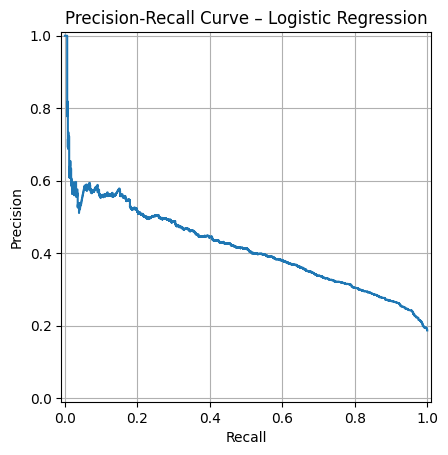

In [51]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_logit)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve – Logistic Regression")
plt.grid(True)
plt.show()

> Highlights the tradeoff between casting a wide net (recall) and keeping predictions precise. The curve shows a sharp drop in precision as recall increases but recall is favored in our use case.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


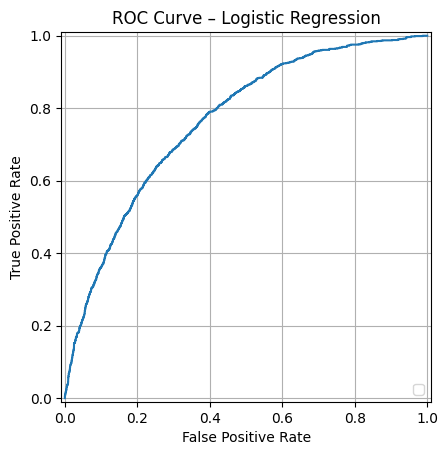

In [52]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_logit)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC Curve – Logistic Regression")
plt.grid(True)
plt.show()

> Reflects overall model discrimination. While decent (AUC = 0.76), ROC AUC is less informative in imbalanced contexts, making precision-recall a better tool for interpreting performance here.

### 6.4.1 Model Evaluation

While the model achieves 67% accuracy, this metric is less meaningful in a **highly imbalanced** setting where **fewer than 1 in 5 merchants are subscribed**. Instead, we focus on recall and precision for the subscribed class:

*   **Recall** (0.72): Captures 72% of actual subscribed merchants, critical for identifying **upsell opportunities**.
*   **Precision** (0.33): One in three flagged merchants are true positives, **acceptable if outreach costs are low**.

Given the GTM context, recall is prioritized: it’s better to surface more high potential merchants, even with some false positives, to **maximize conversion opportunity**.


While logistic regression offers interpretability and a strong baseline, it assumes linear relationships and may miss complex interactions between features. To improve predictive power, we now move to XGBoost, a gradient boosting model that:


*   Captures non-linear patterns and feature interactions
*   Handles sparse and categorical data effectively
Is robust to multicollinearity and more adaptive to real-world behavior

## 6.5 XGBoost Model

Given the **complexity and non linear interactions** in our data, like cohort combinations, regional trends, and merchant tenure, XGBoost is a powerful choice to **benchmark against the baseline model** and explore opportunities to **improve recall and precision**.

It **handles mixed feature types** well, **captures non-linear patterns**, and naturally **deals with missing values**. With **built-in regularization**, it **helps prevent overfitting** while offering **strong performance on imbalanced datasets**. This makes it ideal for surfacing deeper insights beyond what the baseline logistic model can capture.

In [53]:
# Pipeline for numeric features (cap, log1p, scale)
preprocessor_xgb = ColumnTransformer([
    ('num', Pipeline([
        ('cap',  cap_99),
        ('log1p', FunctionTransformer(np.log1p)),
        ('scaler', StandardScaler())
    ]), num_cols),

    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Build XGBoost pipeline
xgb_pipe = Pipeline([
    ('preprocessing', preprocessor_xgb),
    ('classifier', XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        eval_metric='logloss',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        random_state=42
    ))
])

# Fit
xgb_pipe.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_pipe.predict(X_test)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

# Evaluate
print("XGBoost ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost ROC AUC: 0.7663381040613555
              precision    recall  f1-score   support

           0       0.92      0.67      0.77      4802
           1       0.34      0.74      0.47      1103

    accuracy                           0.68      5905
   macro avg       0.63      0.71      0.62      5905
weighted avg       0.81      0.68      0.72      5905



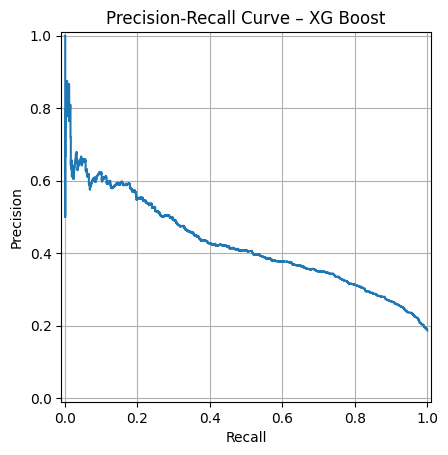

In [54]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve – XG Boost")
plt.grid(True)
plt.show()

> While XGBoost offers slight improvements in mid-range recall, its overall precision-recall curve is comparable to Logistic Regression. This suggests that, with the current features, both models are learning similar patterns, likely driven by dominant signals like cohort and industry. The value of XGBoost may emerge more clearly with further hyperparameter tuning, feature interaction modeling, or decision threshold optimization.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


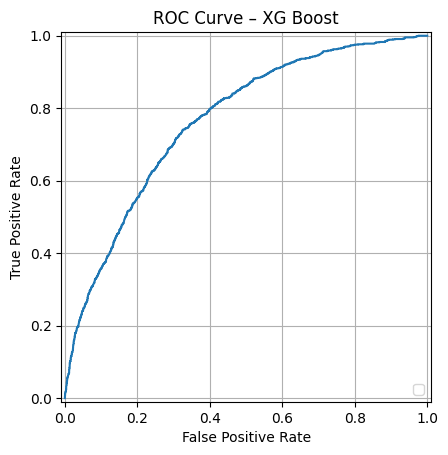

In [55]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC Curve – XG Boost")
plt.grid(True)
plt.show()

> Achieves a decent ROC AUC of 0.76, showing good overall discrimination between classes. While the curve shape is only modestly improved over logistic regression, it offers slightly better separation, especially in the low false positive rate range, which can matter when false alarms carry cost.

### 6.5.1 Tuning the Model

In [56]:
# Hyperparameter grid search
param_dist = {
    'classifier__n_estimators': randint(100, 300),
    'classifier__max_depth': randint(3, 10),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__scale_pos_weight': [1, 3, 5, 7, (y_train == 0).sum() / (y_train == 1).sum()]
}

search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

# Extract best model
best_model = search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


### 6.5.2 Model Evaluation

In [57]:
# Evaluate
y_pred_tuned = best_model.predict(X_test)
y_proba_tuned = best_model.predict_proba(X_test)[:, 1]

print("Tuned XGBoost ROC AUC:", roc_auc_score(y_test, y_proba_tuned))
print(classification_report(y_test, y_pred_tuned))

Tuned XGBoost ROC AUC: 0.7677387179639188
              precision    recall  f1-score   support

           0       0.92      0.67      0.77      4802
           1       0.34      0.73      0.46      1103

    accuracy                           0.68      5905
   macro avg       0.63      0.70      0.62      5905
weighted avg       0.81      0.68      0.72      5905



### 6.5.3 Threshold Optimization

By default, classifiers use a probability threshold of 0.5 to predict class labels. However, this can be suboptimal in imbalanced settings like ours, where fewer than 1 in 5 merchants are subscribed.

Since our goal is to surface as many high potential upsell candidates as possible, we adjust the threshold to favor higher recall, even if it comes at the cost of precision. This helps ensure we don’t miss out on potential subscribers, aligning with FinPay's GTM focus.

We visualize how precision and recall evolve across thresholds to find the right balance.

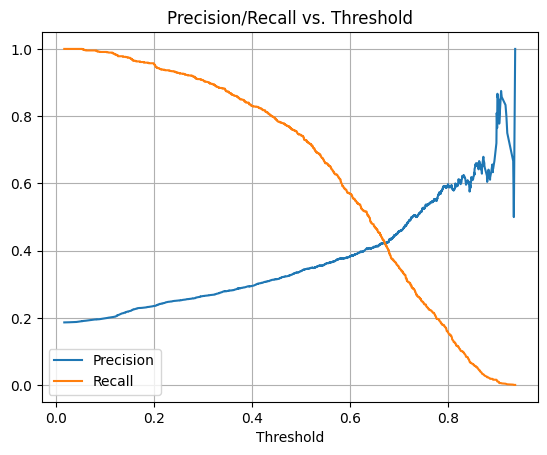

In [58]:
# Get precision, recall, and thresholds from the model's predicted probabilities
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)

# Plot precision vs recall vs threshold
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.title("Precision/Recall vs. Threshold")
plt.legend()
plt.grid()
plt.show()

> This curve confirms that adjusting the threshold below 0.5 helps capture more true positives, aligning with our strategic objective.

In [59]:
# Set precision floor to avoid too many false positives
PRECISION_FLOOR = 0.30

# Filter thresholds where precision ≥ 0.30
valid_idx = np.where(precision >= PRECISION_FLOOR)[0]

# Among those, find the one with the highest recall
best_idx = valid_idx[np.argmax(recall[valid_idx])]
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.2f}")
print(f"Precision: {precision[best_idx]:.2f} | Recall: {recall[best_idx]:.2f}")

Best threshold: 0.41
Precision: 0.30 | Recall: 0.83


In [60]:
# Apply the threshold to predicted probabilities
y_pred_thresh = (y_proba_xgb >= best_threshold).astype(int)

# Evaluate
print("Threshold-Adjusted XGBoost Classification Report")
print(classification_report(y_test, y_pred_thresh))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))

Threshold-Adjusted XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.93      0.56      0.70      4802
           1       0.30      0.83      0.44      1103

    accuracy                           0.61      5905
   macro avg       0.62      0.69      0.57      5905
weighted avg       0.82      0.61      0.65      5905

ROC AUC: 0.7663381040613555


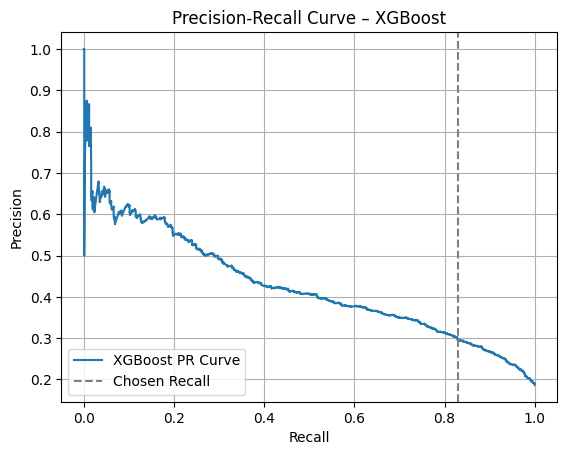

In [61]:
# Use threshold that showed highest recall (0.83)
plt.plot(recall, precision, label='XGBoost PR Curve')
plt.axvline(x=0.83, color='gray', linestyle='--', label='Chosen Recall')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – XGBoost")
plt.grid(True)
plt.legend()
plt.show()

> By choosing a threshold with high recall (~0.83), we ensure that most actual subscribers are identified, increasing the pool of high-potential upsell targets.

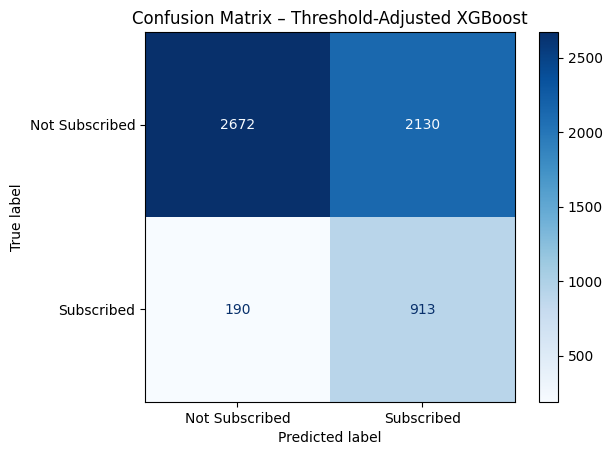

In [62]:
# Assuming you've already applied thresholding:
cm = confusion_matrix(y_test, y_pred_thresh)
ConfusionMatrixDisplay(cm, display_labels=["Not Subscribed", "Subscribed"]).plot(cmap="Blues")
plt.title("Confusion Matrix – Threshold-Adjusted XGBoost")
plt.grid(False)
plt.show()

> The model correctly captures a large portion of actual subscribers (913 out of 1103), reducing missed upsell opportunities. The false positives (2130) are acceptable if follow-up outreach is low cost, supporting our recall-first strategy.

### 6.5.4 Final Model Evaluation

After tuning hyperparameters and adjusting the decision threshold, our final XGBoost model demonstrates strong alignment with business goals:



*  Recall (Subscribed class): 0.83
→ The model successfully identifies 83% of actual subscribers, maximizing upsell coverage.
*   Precision (Subscribed class): 0.30
→ 1 in 3 flagged merchants are true positives, a manageable tradeoff in a high recall setting.
*   ROC AUC: 0.77
→ Confirms solid class separation across thresholds, even in an imbalanced setting.









---

# 7. Final Targeting Insight

I combined **top 20% propensity segmentation** and **cross-tab lift analysis** to surface the most promising GTM upsell targets for FinPay Subscriptions.


## 7.1 Overall Patterns

In [63]:
# Predict subscription propensity using model
merchant_full = merchant_full.reset_index(drop=True)
X = X.reset_index(drop=True)
merchant_full['subscription_propensity'] = best_model.predict_proba(X)[:, 1]

In [64]:
# Rank and score merchants by highest subscription propensity
merchant_full['score_percentile'] = merchant_full['subscription_propensity'].rank(pct=True)
merchant_full = merchant_full.sort_values(by='score_percentile', ascending=False)

# Preview top merchants
merchant_full[['merchant', 'subscription_propensity', 'score_percentile']].head(15)

,merchant,subscription_propensity,score_percentile
11810,801adfa3,0.918991,1.000000
15445,a8120205,0.914449,0.999958
4017,2b06097e,0.913169,0.999915
1216,0de5b7bd,0.910477,0.999873
19683,d4c3e3f8,0.906703,0.999831
15581,a97efa49,0.905443,0.999788
11052,77cf48d7,0.904731,0.999746
2630,1c685864,0.904297,0.999704
14045,988b726f,0.903369,0.999661
14890,a1efde1f,0.901584,0.999619


> Among merchants who have not yet adopted Subscriptions, the model estimates their likelihood to convert based on behavioral and firmographic features. This ranking allows GTM teams to proactively target the top percentile of high-potential leads.

### 7.1.1 Top 20 Propensity Insights

In [65]:
# Get top 20% merchants
top_20th_percentile = merchant_full[merchant_full['score_percentile'] >= 0.80]

# Compare distribution across key categorical features
cat_features = ['country_grouped', 'usage_grouped', 'industry_bucket']

# Show percentage breakdown of top decile vs. overall
for col in cat_features:
    print(f"\n--- {col.upper()} ---")

    # Get normalized value counts (% share)
    top_dist = top_20th_percentile[col].value_counts(normalize=True).rename('Top 20%')
    full_dist = merchant_full[col].value_counts(normalize=True).rename('Overall')

    # Combine into a comparison table
    compare_df = pd.concat([top_dist, full_dist], axis=1).fillna(0) * 100
    compare_df['Lift (%)'] = (compare_df['Top 20%'] - compare_df['Overall']).round(2)

    display(compare_df.sort_values(by='Lift (%)', ascending=False))


--- COUNTRY_GROUPED ---


,Top 20%,Overall,Lift (%)
country_grouped,,,
US,57.820106,36.326686,21.49
CA,5.248677,5.592955,-0.34
ES,1.820106,3.912105,-2.09
AU,3.322751,5.825818,-2.50
IT,0.148148,3.463313,-3.32
GB,10.857143,14.708497,-3.85
FR,2.497354,7.189127,-4.69
Other,18.285714,22.981498,-4.70



--- USAGE_GROUPED ---


,Top 20%,Overall,Lift (%)
usage_grouped,,,
Payment Link,25.121693,13.472205,11.65
Checkout,15.894180,9.792963,6.10
Checkout + Payment Link,4.867725,1.304035,3.56
Custom API / Terminal,54.116402,75.430797,-21.31



--- INDUSTRY_BUCKET ---


,Top 20%,Overall,Lift (%)
industry_bucket,,,
Software / Tech,37.841270,9.153647,28.69
Business Services,23.005291,13.294382,9.71
Personal Services,15.343915,8.124815,7.22
Non-Profit & Membership,9.735450,5.343156,4.39
Finance & Insurance,0.042328,0.071976,-0.03
Healthcare,1.587302,2.692747,-1.11
Education & Training,4.169312,5.631060,-1.46
Digital Goods,3.957672,5.830052,-1.87
Auto & Construction,0.148148,2.028028,-1.88


> Analyzing the top 20% most likely to adopt Subscriptions reveals:
>  
*   **Software/Tech** dominates the top 20% with 38% representation (vs. 9% overall), a +29 pp lift. It’s the strongest signal for upsell propensity
*   **US-based merchants** make up **58% of high-propensity merchants** (vs. 36.3% overall), showing a **+21.49 pp lift**
*   **Payment Link** users show an **12 pp lift**, followed by **Checkout users at +6 pp**, both clear GTM triggers
*   By contrast, **Custom API/Terminal** users are significantly underrepresented (**–21 pp lift**), suggesting lower upsell fit or product maturity.


## 7.2 Cross-Segment Lift Patterns

### 7.2.1 Top 20 Segment Combinations

In [66]:
# Group by each combination of the 3 categorical features
group_cols = ['country_grouped', 'usage_grouped', 'industry_bucket']
overall_counts = merchant_full.groupby(group_cols).size().rename('Overall')
top_counts = top_20th_percentile.groupby(group_cols).size().rename('Top 20%')

# Combine and calculate lift
propensity_lift = pd.concat([top_counts, overall_counts], axis=1).fillna(0)
propensity_lift['Top 20%'] = (propensity_lift['Top 20%'] / top_20th_percentile.shape[0]) * 100
propensity_lift['Overall'] = (propensity_lift['Overall'] / merchant_full.shape[0]) * 100
propensity_lift['Lift (%)'] = (propensity_lift['Top 20%'] - propensity_lift['Overall']).round(2)

# Sort by lift
propensity_lift_sorted = propensity_lift.sort_values(by='Lift (%)', ascending=False).reset_index()
display(propensity_lift_sorted.head(20))

,country_grouped,usage_grouped,industry_bucket,Top 20%,Overall,Lift (%)
0,US,Custom API / Terminal,Software / Tech,13.396825,3.031458,10.37
1,US,Custom API / Terminal,Business Services,11.851852,5.220373,6.63
2,Other,Custom API / Terminal,Software / Tech,5.460317,1.376011,4.08
3,US,Custom API / Terminal,Non-Profit & Membership,5.925926,2.328634,3.60
4,US,Payment Link,Business Services,3.428571,1.058470,2.37
5,US,Custom API / Terminal,Personal Services,4.232804,2.176214,2.06
6,US,Payment Link,Personal Services,2.328042,0.618146,1.71
7,Other,Checkout,Software / Tech,2.116402,0.461493,1.65
8,US,Checkout,Software / Tech,2.010582,0.423388,1.59
9,US,Payment Link,Software / Tech,1.968254,0.431856,1.54


The top 20 high-lift segments reveal clear GTM targeting opportunities:

*   **United States + Custom API + Software/Tech** shows the strongest lift (+10 pp) — prime for direct sales outreach
*   Other high-lift combos include:
  *   **United States + Payment Link + Business Services**
  *   **United States + Checkout + Software/Tech**
  *  **Canada / Great Britain / Australia + Payment Link + Software/Tech**, smaller but still high-propensity pockets globally

---

# Recommendation for GTM Strategy

Prioritize GTM efforts on segments with **consistently high subscription propensity** across dimensions:


### **Primary Targets (High Lift + High Volume)**

- **United States–based Software/Tech** and **Business Services** merchants using **Payment Link** or **Checkout**

- **United States + Custom API + Software/Tech**: ideal for **high-touch sales plays** (e.g. SDR outreach, sandbox demos)


### **Emerging Global Plays (Moderate Lift)**

- **Software/Tech merchants in Great Britain, Canada, and Australia** using **Payment Link** or **Checkout**


### **Deprioritize**  
- **Custom API/Terminal users**, especially **outside Software/Tech**: they show **lower relative propensity** and may already have custom-built stacks.


This strategy ensures focus on the **highest-likelihood segments**, **balancing scale with conversion opportunity** for more effective upsell outcomes.